In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


In [11]:
swissDF  = pd.read_csv("swiss_reviews.csv")

In [12]:
swissDF.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories
0,0,B000R9AAJA,"[0, 0]",5.0,Speakers are loud and clear. They work great! ...,"11 22, 2012",A0023922YYT81KP1CWU4,Steven Caruso,Great!,1353542400,Logitech,"[['Electronics', 'Computers & Accessories', 'C..."
1,1,B000R9AAJA,"[1, 1]",5.0,These I bought for my co-worker who always bor...,"02 3, 2014",A034570920WVP7XFWHZ5I,Olyvia,Co-Worker is happy,1391385600,Logitech,"[['Electronics', 'Computers & Accessories', 'C..."
2,2,B000R9AAJA,"[1, 1]",5.0,I bought these speakers for a friend's birthda...,"02 2, 2013",A100FXXJZMM6PI,Phillip Ly,Logitech S-120 Speakers,1359763200,Logitech,"[['Electronics', 'Computers & Accessories', 'C..."
3,3,B000R9AAJA,"[1, 1]",5.0,My brother bought this speaker set for me back...,"10 20, 2012",A10636NGTJRUHN,sande276,Great!,1350691200,Logitech,"[['Electronics', 'Computers & Accessories', 'C..."
4,4,B000R9AAJA,"[1, 1]",5.0,I have had these for a while and they work lik...,"01 31, 2013",A1071EF3JDBGI0,"R. Lorente ""Picky""",EXCELLENT!,1359590400,Logitech,"[['Electronics', 'Computers & Accessories', 'C..."


We'll first look at the overall ratings, all categories mixed together

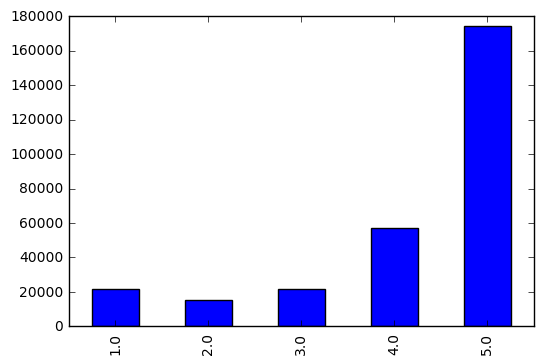

In [13]:
swissDF.overall.value_counts().sort_index().plot.bar()

The ratings are pretty high, but as we have determined before this is also the case for international products. So basing our observations on raw evaluations isn't enough, we'll try to separate them by categories and perform sentiment analysis

In [14]:
swissDF['year'] = swissDF['reviewTime'].astype(str)
swissDF['year'] = swissDF['year'].apply(lambda x: x[-4:])

In [15]:
yearGroup =swissDF.groupby(['year'])
yearGroup['overall'].agg(['count', 'mean'])

,count,mean
year,,
2000,12,4.416667
2001,49,3.918367
2002,70,3.942857
2003,205,4.136585
2004,307,3.491857
2005,826,3.984262
2006,1893,4.078711
2007,5514,4.273486
2008,7366,4.250068


The mean seems pretty consistent. with a few exceptions like 2004 which is probably due to a very inpopular product released back then. It also seems like the number of reviews is increasing exponentially.

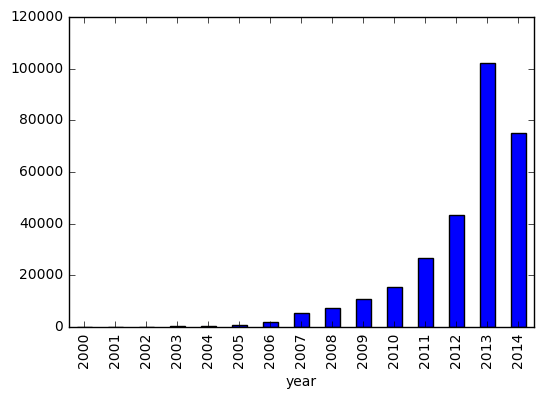

In [16]:
yearGroup['overall'].count().plot.bar()

2014 might seem smaller than 2013, but this data was collected in July 2014 which explains it.